In [53]:
from datetime import datetime

import akshare as ak  # 升级到最新版
import backtrader as bt  # 升级到最新版
import matplotlib.pyplot as plt  # 由于 Backtrader 的问题，此处要求 pip install matplotlib==3.2.2
import pandas as pd
import pyfolio as pf
import quantstats as qs
import platform
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager

def set_chinese_font():
    system = platform.system()  # 获取操作系统名称
    if system == "Windows":
        # Windows 使用 SimHei
        rcParams['font.sans-serif'] = ['SimHei']
    elif system == "Darwin":
        # macOS 使用 PingFang SC
        rcParams['font.sans-serif'] = ['Heiti TC']
    else:
        # 其他系统提示用户自行安装字体
        raise EnvironmentError("Unsupported OS. Please install a suitable Chinese font.")

    # 解决负号显示问题
    rcParams['axes.unicode_minus'] = False

# 设置字体
set_chinese_font()
# 利用 AKShare 获取股票的后复权数据，这里只获取前 6 列
stock_hfq_df = ak.stock_zh_a_hist(symbol="600256", adjust="hfq").iloc[:, :7]
# 删除 `股票代码` 列
del stock_hfq_df['股票代码']
# 处理字段命名，以符合 Backtrader 的要求
stock_hfq_df.columns = [
    "date",
    "open",
    "close",
    "high",
    "low",
    "volume",
]
# 把 date 作为日期索引，以符合 Backtrader 的要求
stock_hfq_df.index = pd.to_datetime(stock_hfq_df["date"])

class MyStrategy(bt.Strategy):
    """
    主策略程序
    """
    # 设定交易策略的参数
    params = dict(
        maperiod=20,
    )
    def __init__(self):
        """
        初始化函数
        """
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buy_price = None
        self.buy_comm = None
        # 添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0].lines.close, period=self.params.maperiod
        )
        self.sma.csv = True

    def next(self):
        """
        执行逻辑
        """
        if self.order:  # 检查是否有指令等待执行，如果有未完成的订单则跳过
            return
        # 检查是否持仓
        if not self.position:  # 没有持仓
            # 执行买入条件判断：收盘价格上涨突破 20 日均线
            if self.datas[0].lines.close[-1] < self.sma[-1] and self.datas[0].lines.close[0] > self.sma[0]:
                self.order = self.buy(size=100)  # 执行买入
        # 执行卖出条件判断：收盘价格跌破 20 日均线
        elif self.datas[0].lines.close[-1] > self.sma[-1] and self.datas[0].lines.close[0] < self.sma[0]:
            self.order = self.sell(size=100)  # 执行卖出


初始资金: 1000000
回测期间：20000403:20210912
总资金: 1025603.9
净收益: 25603.9
index
2000-05-26 00:00:00+00:00    0.000000
2000-05-29 00:00:00+00:00    0.000000
2000-05-30 00:00:00+00:00    0.000000
2000-05-31 00:00:00+00:00    0.000000
2000-06-01 00:00:00+00:00    0.000000
                               ...   
2021-09-06 00:00:00+00:00    0.001011
2021-09-07 00:00:00+00:00    0.000433
2021-09-08 00:00:00+00:00   -0.000289
2021-09-09 00:00:00+00:00    0.002597
2021-09-10 00:00:00+00:00    0.001008
Name: return, Length: 5055, dtype: float64


Start date,2000-05-26
End date,2021-09-10
Total months,240
,Backtest
Annual return,0.126%
Cumulative returns,2.56%
Annual volatility,0.675%
Sharpe ratio,0.19
Calmar ratio,0.04
Stability,0.24
Max drawdown,-3.181%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.18,2013-03-25,2021-02-01,NaT,NaN
1,1.36,2010-12-13,2012-01-05,2013-02-28,579
2,0.80,2007-11-02,2008-10-14,2009-07-27,452
3,0.50,2002-06-25,2005-07-18,2007-05-08,1271
4,0.43,2010-06-11,2010-07-05,2010-10-08,86


/Users/xk/python_project/backtrader/.conda/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Dotcom,0.00%,-0.01%,0.01%
Lehman,-0.01%,-0.05%,0.04%
9/11,-0.00%,-0.02%,0.01%
US downgrade/European Debt Crisis,-0.01%,-0.12%,0.07%
Fukushima,0.02%,-0.11%,0.16%
US Housing,0.00%,-0.01%,0.02%
EZB IR Event,0.02%,-0.08%,0.18%
Aug07,0.01%,-0.03%,0.06%
Mar08,-0.01%,-0.06%,0.04%
Sept08,-0.00%,-0.04%,0.03%


                           Strategy
-------------------------  ----------
Start Period               2000-05-26
End Period                 2021-09-10
Risk-Free Rate             0.0%
Time in Market             95.0%

Cumulative Return          2.56%
CAGR﹪                     0.08%

Sharpe                     0.19
Prob. Sharpe Ratio         80.21%
Smart Sharpe               0.18
Sortino                    0.27
Smart Sortino              0.26
Sortino/√2                 0.19
Smart Sortino/√2           0.18
Omega                      1.04

Max Drawdown               -3.18%
Longest DD Days            3091
Volatility (ann.)          0.68%
Calmar                     0.03
Skew                       -0.31
Kurtosis                   9.9

Expected Daily %           0.0%
Expected Monthly %         0.01%
Expected Yearly %          0.11%
Kelly Criterion            2.06%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.07%
Expected Shortfall (cVaR)  -0.07%

Max Consecutive Wins       11
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2013-03-26,2021-02-01,2021-09-10,3091,-3.181176,-3.145698
2,2010-12-14,2012-01-05,2013-02-27,807,-1.360248,-1.246207
3,2007-11-05,2008-10-14,2009-07-24,628,-0.803567,-0.786091
4,2002-06-26,2005-07-18,2007-04-30,1770,-0.499600,-0.494218
5,2010-06-17,2010-07-05,2010-09-30,106,-0.433337,-0.416858


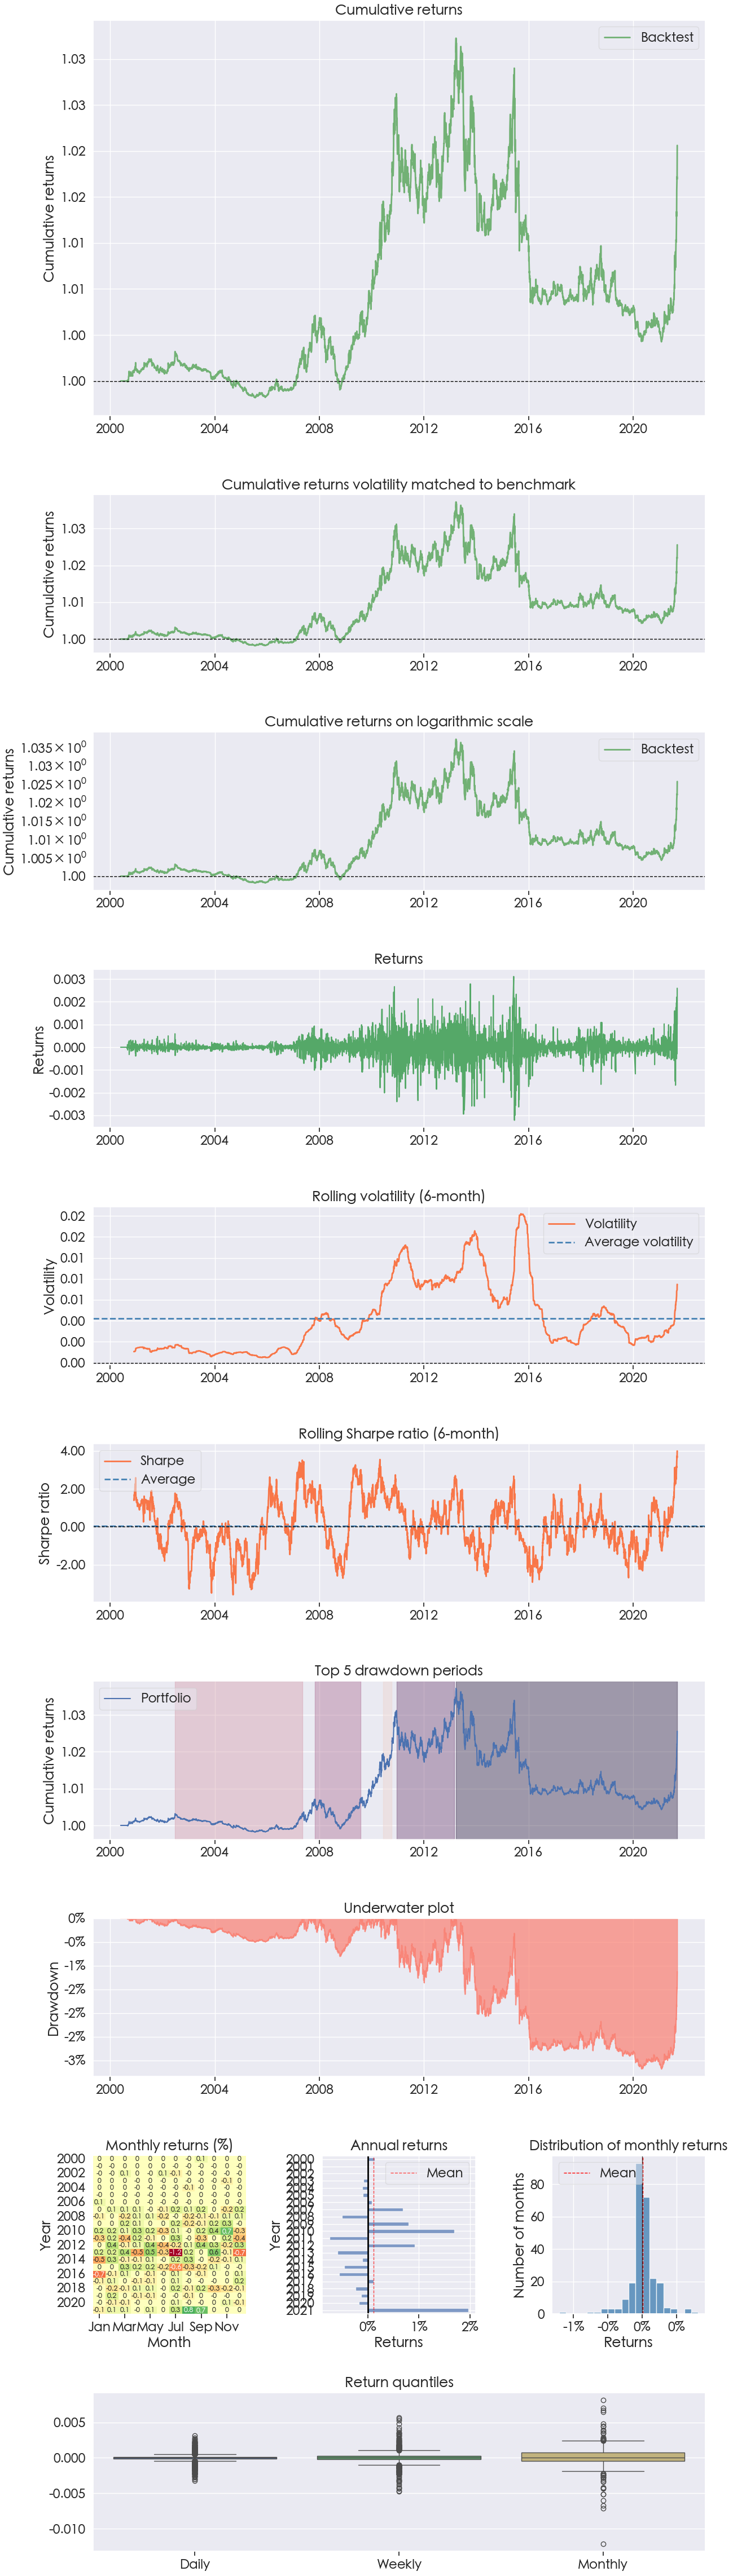

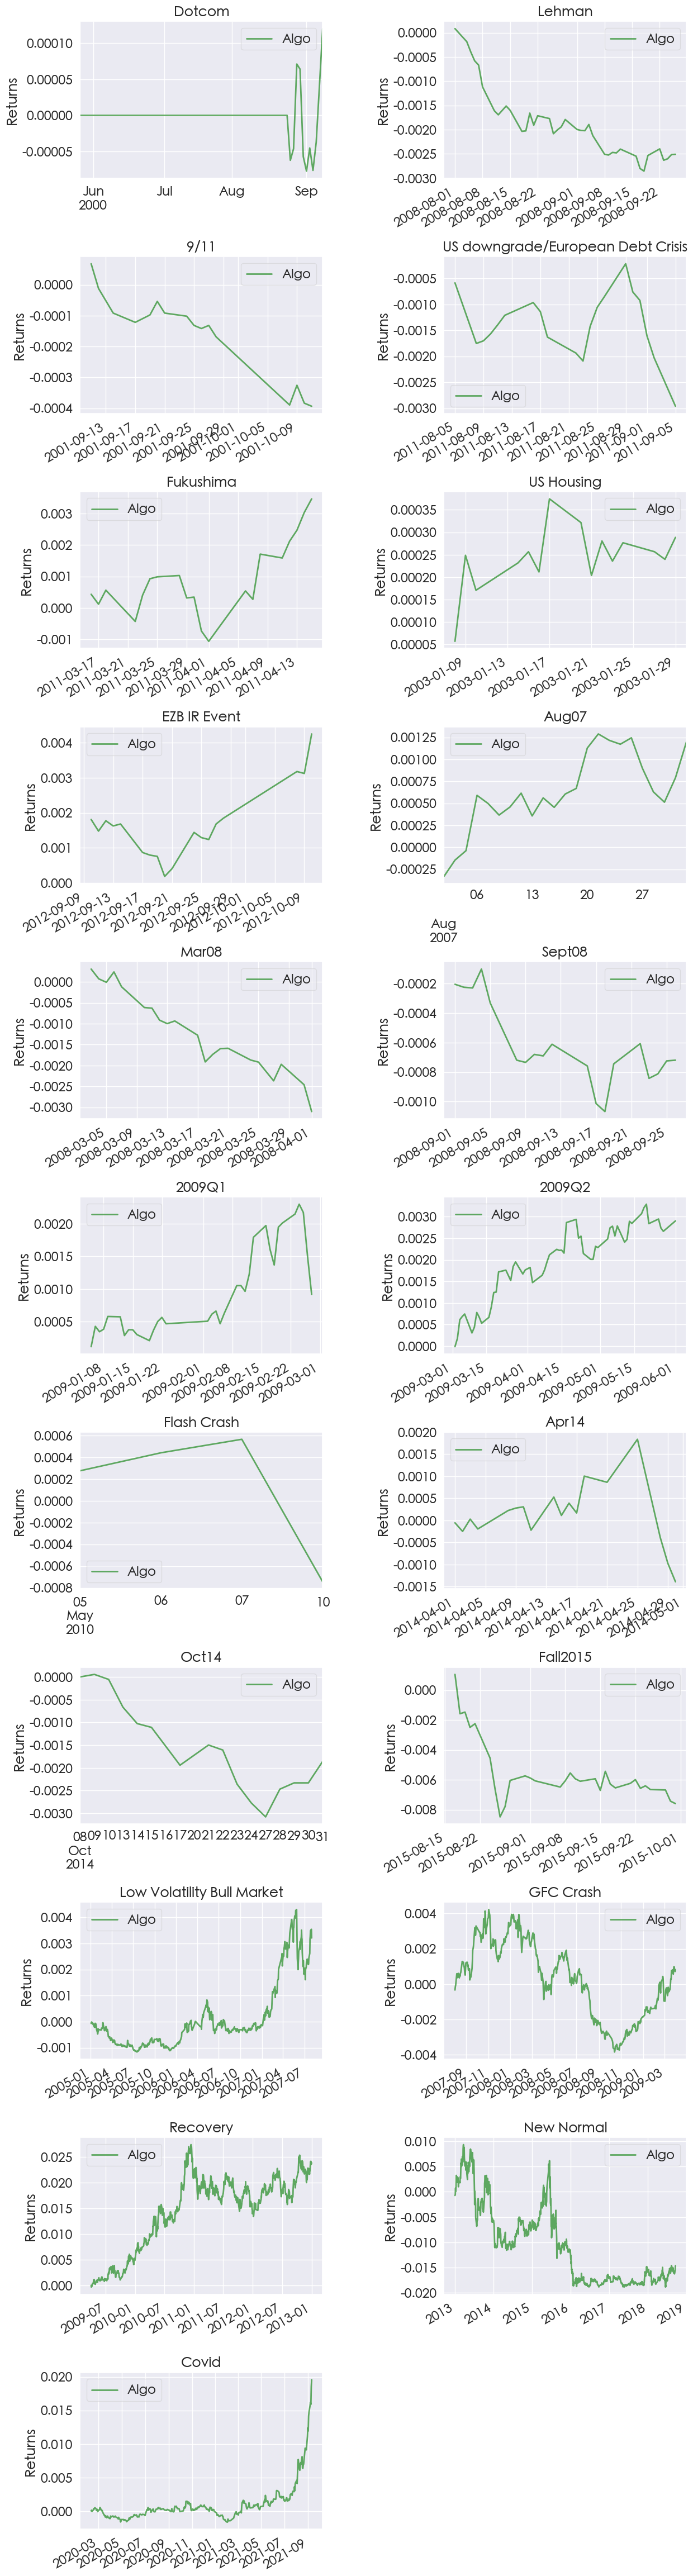

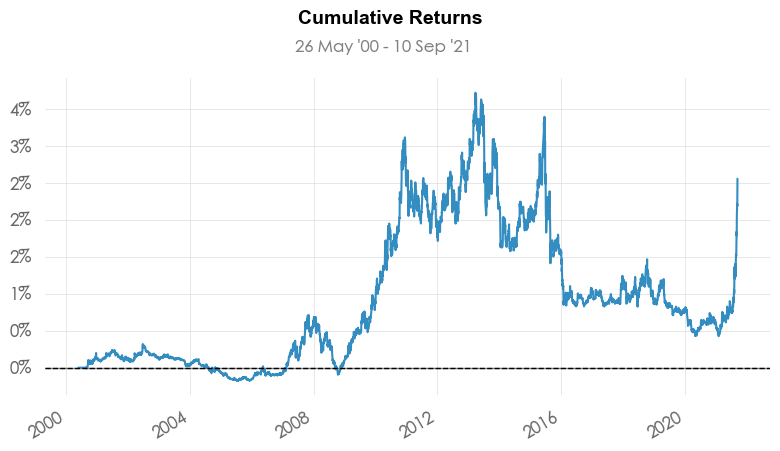

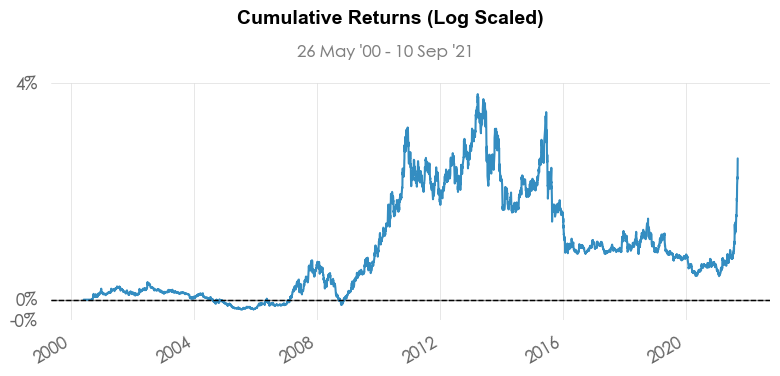

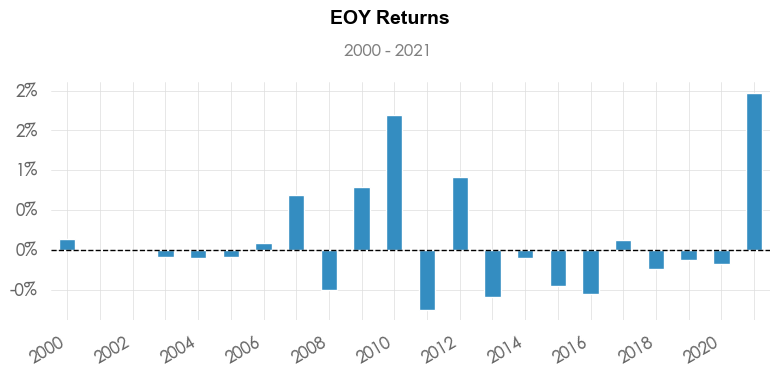

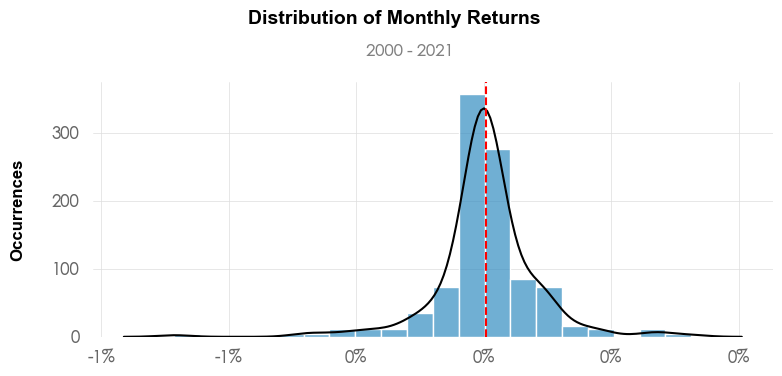

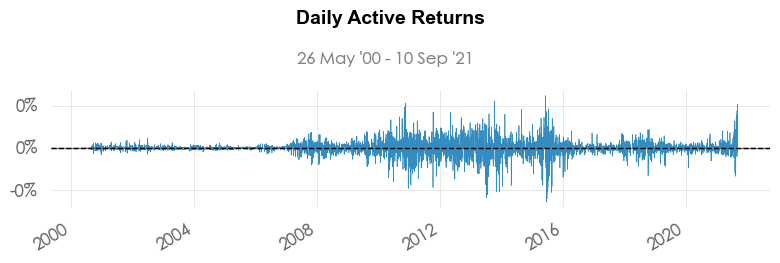

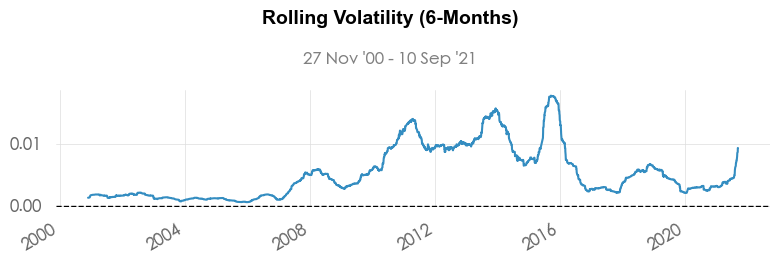

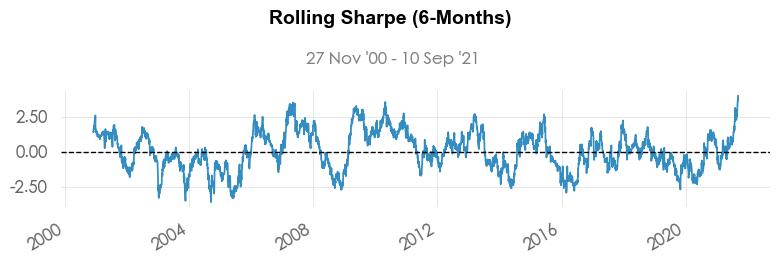

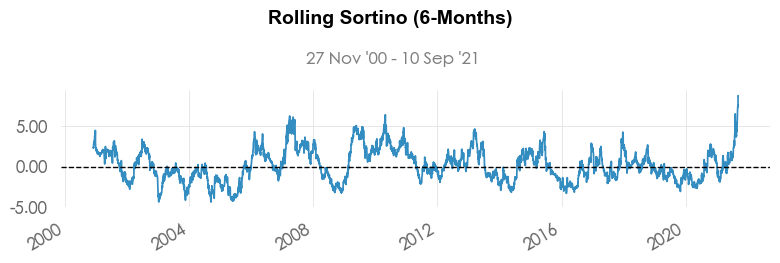

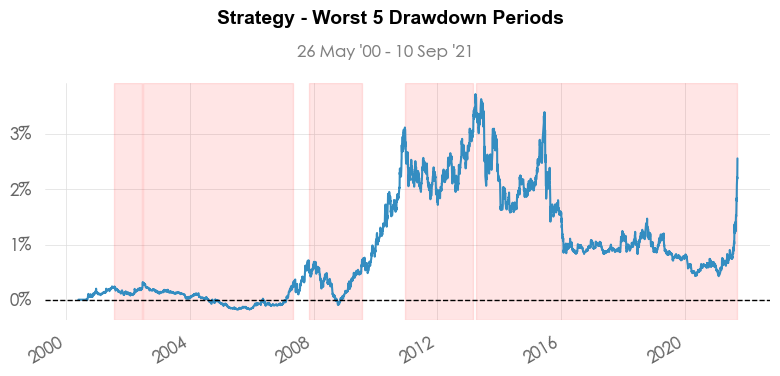

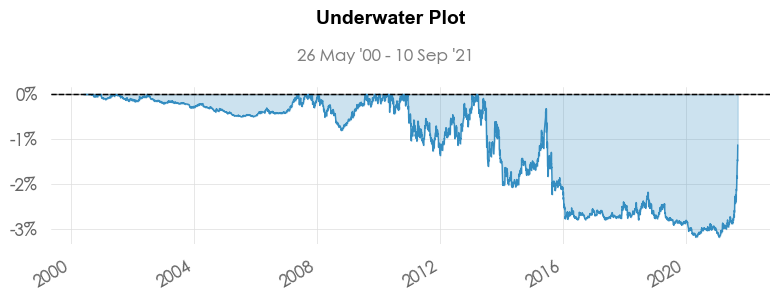

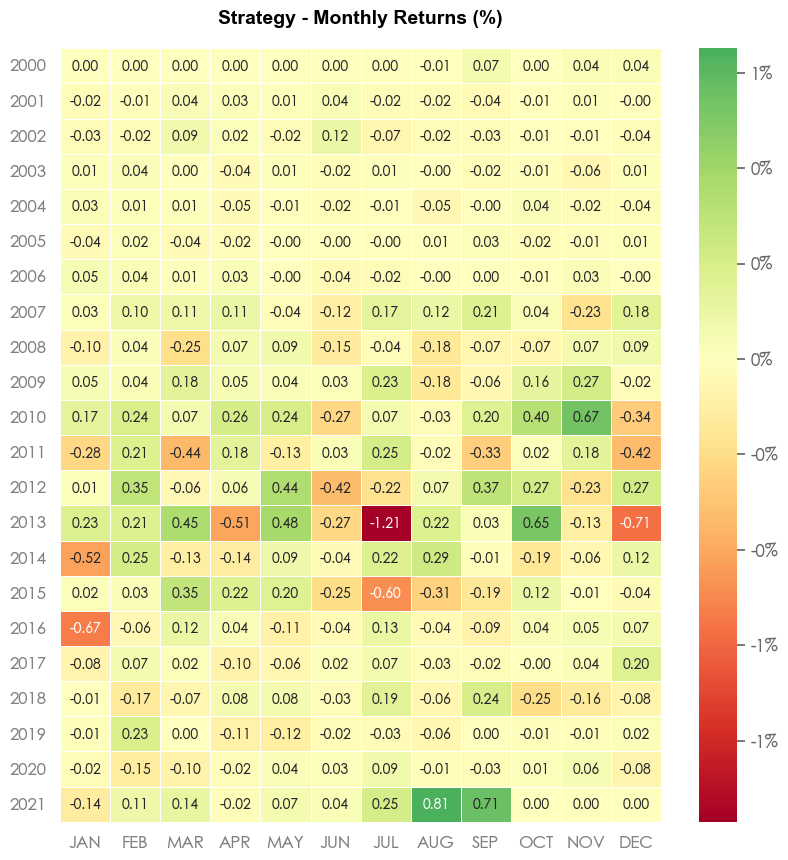

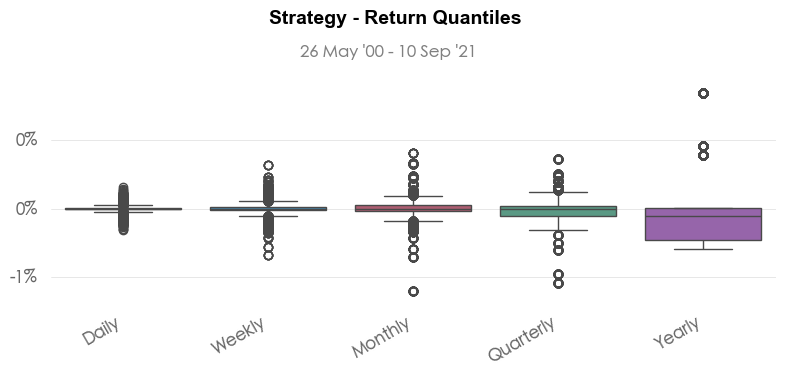

Help on function conditional_value_at_risk in module quantstats.stats:

conditional_value_at_risk(returns, sigma=1, confidence=0.95, prepare_returns=True)
    Calculats the conditional daily value-at-risk (aka expected shortfall)
    quantifies the amount of tail risk an investment



[*********************100%***********************]  1 of 1 completed


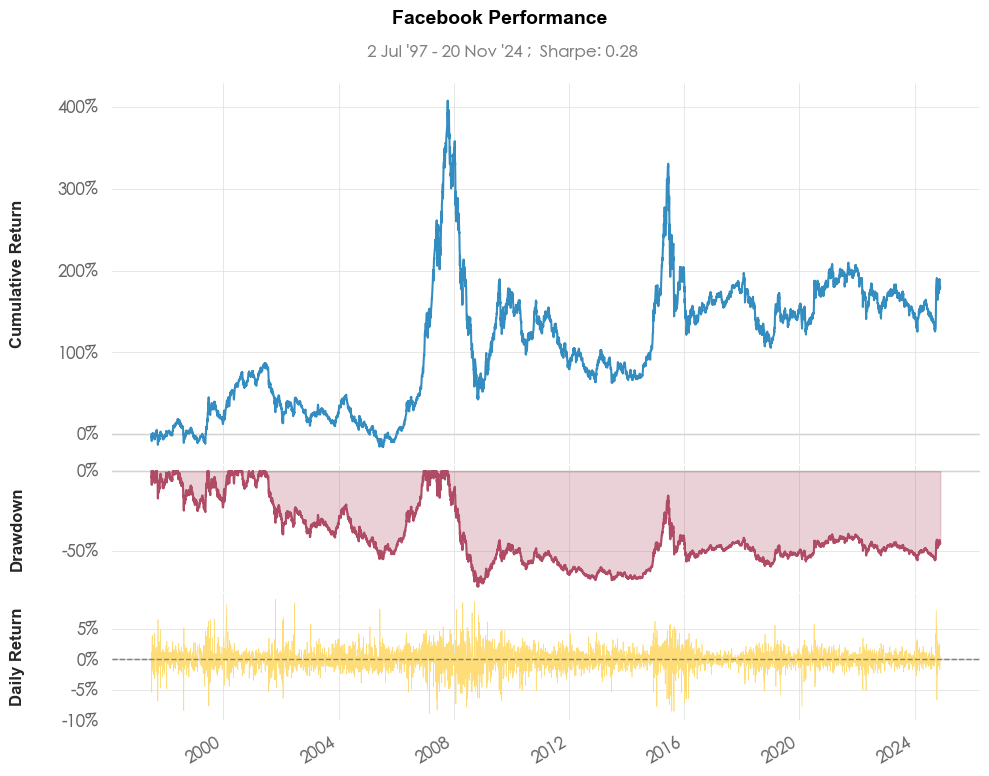

In [54]:
cerebro = bt.Cerebro()  # 初始化回测系统
start_date = datetime(2000, 4, 3)  # 回测开始时间
end_date = datetime(2021, 9, 12)  # 回测结束时间
data = bt.feeds.PandasData(
    dataname=stock_hfq_df, fromdate=start_date, todate=end_date
)  # 加载数据
cerebro.adddata(data)  # 将数据传入回测系统
cerebro.addstrategy(MyStrategy)  # 将交易策略加载到回测系统中

# 添加观察者 PyFolio
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
# 添加书写者
cerebro.addwriter(bt.WriterFile, csv=True, out="result.csv")

start_cash = 1000000
cerebro.broker.setcash(start_cash)  # 设置初始资本为 100000
cerebro.broker.setcommission(commission=0.002)  # 设置交易手续费为 0.2%
result = cerebro.run()[0]  # 运行回测系统

port_value = cerebro.broker.getvalue()  # 获取回测结束后的总资金
pnl = port_value - start_cash  # 盈亏统计

print(
    f"初始资金: {start_cash}\n回测期间：{start_date.strftime('%Y%m%d')}:{end_date.strftime('%Y%m%d')}"
)
print(f"总资金: {round(port_value, 2)}")
print(f"净收益: {round(pnl, 2)}")

# cerebro.plot(style="candlestick")  # 画图

portfolio_stats = result.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
print(returns)
pf.create_full_tear_sheet(returns)
qs.reports.full(returns)

qs.stats.sharpe(returns)
qs.stats.conditional_value_at_risk(returns)

help(qs.stats.conditional_value_at_risk)
qs.extend_pandas()
stock = qs.utils.download_returns('000001.SS')
stock.sharpe()
qs.plots.snapshot(stock['000001.SS'], title='Facebook Performance')
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, benchmark=stock['000001.SS'],benchmark_title="Facebook", output='stats.html', title='Report')  # 会在本地目录生成 html 文件，用游览器打开即可


In [55]:
import matplotlib
from matplotlib import font_manager
 
font_list=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for i in font_list:
    print(i)

.Aqua Kana
.Keyboard
.New York
.New York
.SF Arabic
.SF Compact
.SF Compact
.SF Compact Rounded
.SF NS Mono
.SF NS Mono
.SF NS Rounded
Academy Engraved LET
Al Bayan
Al Nile
Al Tarikh
American Typewriter
Andale Mono
Apple Braille
Apple Braille
Apple Braille
Apple Braille
Apple Braille
Apple Chancery
Apple LiGothic
Apple LiSung
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyungjo
Arial
Arial
Arial
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Narrow
Arial Narrow
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Arial Unicode MS
Athelas
Avenir
Avenir Next
Avenir Next Condensed
Ayuthaya
BM Dohyeon
BM Hanna 11yrs Old
BM Hanna Air
BM Hanna Pro
BM Jua
BM Kirang Haerang
BM Yeonsung
Baghdad
Bangla MN
Bangla Sangam MN
Baoli SC
Baskerville
Beirut
BiauKai
Big Caslon
Bodoni 72
Bodoni 72 Oldstyle
Bodoni 72 Smallcaps
Bodoni Ornaments
Bradley Hand
Brush Script MT
Chalkboard
Chalkboard SE
Chalkduster
Charter
Cochin
Comic Sans MS
Comic Sans MS
Copperplate
Corsiva Hebrew
Courier
Courier New
C

In [56]:
type(stock['000001.SS'])

pandas.core.series.Series